In [13]:
import nbformat

def remove_widget_metadata(notebook_path):
    """
    Removes the 'widgets' metadata from a Jupyter notebook.

    Args:
        notebook_path (str): The path to the .ipynb file.
    """
    try:
        with open(notebook_path, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)

        if 'widgets' in nb.metadata:
            del nb.metadata['widgets']

        with open(notebook_path, 'w', encoding='utf-8') as f:
            nbformat.write(nb, f)
        print(f"Successfully removed widget metadata from {notebook_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage:
# remove_widget_metadata('your_problematic_notebook.ipynb')

# The Continuous Thought Machine – Tutorial [![arXiv](https://img.shields.io/badge/arXiv-2505.05522-b31b1b.svg)](https://arxiv.org/abs/2505.05522)

Tutorial traduzido e adaptado de [SAKA IA](https://github.com/SakanaAI/continuous-thought-machines), onde os autores do modelo abordam um exemplo de carregamento de uma CTM pré-treinada e seu uso para inferência.

### Instalar

Como em qualquer laboratório, o primeiro passo é técnico: instalar as ferramentas necessárias e baixar o "cérebro" da IA, um modelo pré-treinado com milhões de imagens (o famoso dataset [ImageNet](https://www.image-net.org/)).

In [ ]:
!pip install mediapy
!git clone https://github.com/SakanaAI/continuous-thought-machines.git
!pip install gdown

Em seguida, baixamos o ponto de verificação do CTM do [Google Drive](https://drive.google.com/file/d/1Lr_3RZU9X9SS8lBhAhECBiSZDKfKhDkJ/view?usp=drive_link) e o descompactamos - *unzip*.

In [ ]:
!gdown https://drive.google.com/uc?id=1Lr_3RZU9X9SS8lBhAhECBiSZDKfKhDkJ
!unzip  imagenet.zip

CHECKPOINT_PATH = "imagenet/ctm_imagenet_D=4096_T=50_M=25.pt"

Imports

In [3]:
import sys
sys.path.append("continuous-thought-machines")

import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from models.ctm import ContinuousThoughtMachine as CTM
import urllib
from IPython.display import Image as IPyImage, display
from pprint import pprint
import numpy as np
import seaborn as sns
import os
import torch.nn.functional as F
from matplotlib import patheffects
from scipy import ndimage
import imageio
import mediapy
from tasks.image_classification.plotting import plot_neural_dynamics
from tasks.image_classification.imagenet_classes import IMAGENET2012_CLASSES

### Carregar o Modelo

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)

# The args used for instantiating the model
model_args = checkpoint['args']

Podemos ver a "estrutura" (hiperparâmetros) do modelo:

- **4.096 neurônios artificiais** (d_model): As unidades básicas de processamento, funcionando como uma versão simplificada dos neurônios do nosso cérebro.
- **50 tiques internos** (iterations): Os "passos" que a IA dá para pensar sobre a imagem. A cada passo, ela reavalia e ajusta sua conclusão, como quando nossa amiga olha primeiro os contornos, depois as orelhas, depois a cauda do animal.
- **25 memórias** (memory_length): A capacidade de "lembrar" dos passos de pensamento anteriores para construir uma conclusão mais sólida. É como se a IA pudesse dizer: "Baseado no que já analisei, agora vou focar neste detalhe."
- **Sincronização** (Synch): Um mecanismo que permite que diferentes partes da rede neural trabalhem em conjunto, de forma coordenada, como diferentes regiões do nosso cérebro colaborando para reconhecer uma imagem.

```
O que são hiperparâmetros?
Imagine que você está aprendendo a cozinhar. Antes de começar, você precisa definir algumas coisas: qual temperatura do forno usar, por quanto tempo cozinhar, quanta água adicionar. Essas são suas "regras de preparo". Os hiperparâmetros funcionam de forma similar para a inteligência artificial. São as "regras de aprendizado" que os cientistas definem antes de treinar uma IA.
Assim como a temperatura errada pode queimar seu bolo, hiperparâmetros mal configurados podem fazer a IA aprender de forma incorreta. Por isso, encontrar a combinação certa dessas configurações é fundamental para que a IA funcione bem. Em resumo: hiperparâmetros são as configurações que controlam como uma IA aprende, definidas antes do treinamento começar.
```

In [5]:
pprint(vars(model_args))

{'backbone_type': 'resnet152-4',
 'd_input': 1024,
 'd_model': 4096,
 'deep_memory': True,
 'do_normalisation': False,
 'heads': 16,
 'iterations': 50,
 'memory_hidden_dims': 64,
 'memory_length': 25,
 'n_random_pairing_self': 32,
 'n_synch_action': 2048,
 'n_synch_out': 8196,
 'neuron_select_type': 'random-pairing',
 'out_dims': 1000,
 'positional_embedding_type': 'none',
 'synapse_depth': 8}


In [6]:
model = CTM(
    iterations=model_args.iterations,
    d_model=model_args.d_model,
    d_input=model_args.d_input,
    heads=model_args.heads,
    n_synch_out=model_args.n_synch_out,
    n_synch_action=model_args.n_synch_action,
    synapse_depth=model_args.synapse_depth,
    memory_length=model_args.memory_length,
    deep_nlms=model_args.deep_memory,
    memory_hidden_dims=model_args.memory_hidden_dims,
    do_layernorm_nlm=model_args.do_normalisation,
    backbone_type=model_args.backbone_type,
    positional_embedding_type=model_args.positional_embedding_type,
    out_dims=model_args.out_dims,
    prediction_reshaper=[-1],
    dropout=0,
    neuron_select_type=model_args.neuron_select_type,
    n_random_pairing_self=model_args.n_random_pairing_self,
).to(device)

load_result = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.eval(); # Set model to evaluation mode

Using neuron select type: random-pairing
Synch representation size action: 2048
Synch representation size out: 8196


### Fazer o upload de uma imagem

Em seguida alimentamos o sistema com uma **nova imagem**

O objetivo é que a CTM, que nunca viu essa foto específica antes, consiga identificá-la corretamente como uma "raposa-vermelha".


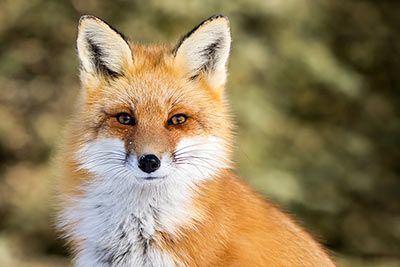

In [7]:
url = "https://www.animalfunfacts.net/images/stories/photos/mammals/carnivores/fox/red_fox_m.jpg" # você pode trocar o link para outro desejado
filename="fox.jpg"

target=277 # Fox corresponds to index 277 in IMAGENET2012_CLASSES https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
urllib.request.urlretrieve(url, filename) # Download the image

image = Image.open("fox.jpg").convert("RGB")
display(image)

**Tratamos a imagem**: Redimensionamos, cortamos e normalizamos a imagem e a convertemos em um tensor PyTorch.

In [8]:
dataset_mean = [0.485, 0.456, 0.406]
dataset_std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=dataset_mean,
        std=dataset_std
    )
])

input_tensor = transform(image).unsqueeze(0).to(device)

### Reconhecendo a imagem - inferencia

**Vamos executar o modelo para obter a predição da CTM, junto com alguns dados que usaremos para visualização.**

Especificamente, o modelo produz:

* **`predictions` (predições):** As "apostas" da IA a cada tique interno - mostra o que ela pensa que vê em cada momento (Formato: B, C, T)

* **`certainties` (certezas):** O nível de confiança da IA a cada tique - quanto mais próximo de 1, mais certa ela está (Formato: B, 2, T)

* **`synchronization` (sincronização):** Como diferentes partes da rede neural se coordenam ao longo do tempo (Formato de cada: T, B, tamanho_da_representação)

* **`pre_activations` (pré-ativações):** O histórico de como os neurônios estavam "se preparando" para processar a informação (Formato: T, B, d_model)

* **`post_activations` (pós-ativações):** O histórico de como os neurônios processaram a informação (Formato: T, B, d_model)

* **`attention_tracking` (rastreamento de atenção):** Onde exatamente a IA estava "olhando" na imagem a cada momento - são os dados que geram aqueles mapas de calor coloridos (Formato: T, B, num_heads, 1, 196)

**Em termos simples:** Esses dados nos permitem ver não apenas o que a IA decidiu, mas todo o processo de como ela chegou a essa decisão, passo a passo.


In [9]:
predictions, certainties, synchronization, pre_activations, post_activations, attention_tracking = model(input_tensor, track=True)

Vamos ver o que a CTM previu em

1. o tique interno final e

2. o tique interno com maior certeza

Em outras palavras:

1. **No último momento:** O que a IA decidiu após completar todo seu processo de "reflexão"

2. **No momento de maior confiança:** Em qual ponto do processo a IA ficou mais certa de sua resposta - e o que ela pensou naquele momento

Isso nos ajuda a entender se a IA melhora suas previsões conforme "pensa" mais, ou se ela já tinha a resposta certa em algum ponto anterior e depois ficou em dúvida.

In [10]:
# 1) tique interno final
prediction_last = predictions[0, :, -1].argmax(dim=0)
IMAGENET_CLASS_LIST = list(IMAGENET2012_CLASSES.values())

print(f"Target Class: {target} = {IMAGENET_CLASS_LIST[target]}")
print(f"Predicted Class (final): {prediction_last.item()} = {IMAGENET_CLASS_LIST[prediction_last.item()]}")

# 2) tique interno com maior certeza
where_most_certain = certainties[:,1].argmax(-1)
B = 1
prediction_most_certain = predictions.argmax(1)[torch.arange(B, device=predictions.device),where_most_certain]
print(f"Predicted Class (most certain): {prediction_most_certain.item()} = {IMAGENET_CLASS_LIST[prediction_most_certain.item()]}")

Target Class: 277 = red fox, Vulpes vulpes
Predicted Class (final): 277 = red fox, Vulpes vulpes
Predicted Class (most certain): 277 = red fox, Vulpes vulpes


### Visualizando o Pensamento da IA

A parte mais incrível do trabalho do Sakana AI é que eles criaram uma forma de visualizar esse processo de pensamento. Eles geraram um GIF que nos permite ver o “processo de reconhecimento" da IA em funcionamento.

In [11]:
def make_gif(predictions, certainties, attention_tracking, ground_truth_target, out_path, dataset_mean, dataset_std):

   def find_island_centers(array_2d, threshold):
       """
       Encontra o centro de massa de cada ilha (componente conectado > threshold)
       em um array 2D, ponderado pelos valores do array.
       Retorna lista de centros (y, x) e lista de áreas.
       """
       binary_image = array_2d > threshold
       labeled_image, num_labels = ndimage.label(binary_image)
       centers = []
       areas = []
       # Calcula o centro de massa para cada ilha rotulada (rótulo 0 é o fundo)
       for i in range(1, num_labels + 1):
           island_mask = (labeled_image == i)
           total_mass = np.sum(array_2d[island_mask])
           if total_mass > 0:
               # Obtém coordenadas para esta ilha
               y_coords, x_coords = np.mgrid[:array_2d.shape[0], :array_2d.shape[1]]
               # Calcula média ponderada para o centro
               x_center = np.average(x_coords[island_mask], weights=array_2d[island_mask])
               y_center = np.average(y_coords[island_mask], weights=array_2d[island_mask])
               centers.append((round(y_center, 4), round(x_center, 4)))
               areas.append(np.sum(island_mask)) # Área é a contagem de pixels na ilha
       return centers, areas

   interp_mode = 'nearest'
   figscale = 0.85

   class_labels = list(IMAGENET2012_CLASSES.values()) # Carrega nomes reais das classes

   # predictions: (B, Classes, Steps), attention_tracking: (Steps*B*Heads, SeqLen)
   n_steps = predictions.size(-1)

   # --- Reformata Atenção ---
   # Infere o tamanho do mapa de características dos internos do modelo (assumindo B=1)
   h_feat, w_feat = model.kv_features.shape[-2:]

   n_heads = attention_tracking.shape[2]
   # Reformata para (Steps, Heads, H_feat, W_feat) assumindo B=1
   attention_tracking = attention_tracking.reshape(n_steps, n_heads, h_feat, w_feat)

   # --- Configuração para Plotagem ---
   step_linspace = np.linspace(0, 1, n_steps) # Para cores dos passos
   # Define mapas de cores
   cmap_spectral = sns.color_palette("Spectral", as_cmap=True)
   cmap_attention = sns.color_palette('viridis', as_cmap=True)

   # Cria diretório de saída para este índice
   index_output_dir = os.path.join(out_path, str(0))
   os.makedirs(index_output_dir, exist_ok=True)

   frames = [] # Armazena frames para GIF
   head_routes = {h: [] for h in range(n_heads)} # Armazena pontos de caminho (y,x) por cabeça
   head_routes[-1] = []
   route_colours_step = [] # Armazena cores para cada segmento de caminho dos passos

   # --- Loop Através de Cada Passo ---
   for step_i in range(n_steps):

       # --- Prepara Imagem para Exibição ---
       # Desnormaliza o tensor de entrada para visualização
       data_img_tensor = input_tensor[0].cpu() # Obtém primeiro item do lote, move para CPU
       mean_tensor = torch.tensor(dataset_mean).view(3, 1, 1)
       std_tensor = torch.tensor(dataset_std).view(3, 1, 1)
       data_img_denorm = data_img_tensor * std_tensor + mean_tensor
       # Permuta para (H, W, C) e converte para numpy, limita a [0, 1]
       data_img_np = data_img_denorm.permute(1, 2, 0).detach().numpy()
       data_img_np = np.clip(data_img_np, 0, 1)
       img_h, img_w = data_img_np.shape[:2]

       # --- Processa Atenção & Certeza ---
       # Média de atenção sobre os últimos passos (do código original)
       start_step = max(0, step_i - 5)
       attention_now = attention_tracking[start_step : step_i + 1].mean(0) # Média sobre passos -> (Heads, H_feat, W_feat)
       # Obtém certezas até o passo atual
       certainties_now = certainties[0, 1, :step_i+1].detach().cpu().numpy() # Assumindo que índice 1 contém certeza relevante

       # --- Calcula Caminhos de Atenção (usando interpolação bilinear) ---
       # Interpola atenção para tamanho da imagem usando bilinear para encontrar centro
       attention_interp_bilinear = F.interpolate(
           torch.from_numpy(attention_now).unsqueeze(0).float(), # Adiciona dimensão do lote, garante float
           size=(img_h, img_w),
           mode=interp_mode,
           # align_corners=False
       ).squeeze(0) # Remove dimensão do lote -> (Heads, H, W)

       # Normaliza mapa de cada cabeça para [0, 1]
       # Lida com média
       attn_mean = attention_interp_bilinear.mean(0)
       attn_mean_min = attn_mean.min()
       attn_mean_max = attn_mean.max()
       attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)
       centers, areas = find_island_centers(attn_mean.detach().cpu().numpy(), threshold=0.7)

       if centers: # Se ilhas foram encontradas
           largest_island_idx = np.argmax(areas)
           current_center = centers[largest_island_idx] # (y, x)
           head_routes[-1].append(current_center)
       elif head_routes[-1]: # Se não há centro agora, repete último centro conhecido se histórico existe
           head_routes[-1].append(head_routes[-1][-1])


       attn_min = attention_interp_bilinear.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
       attn_max = attention_interp_bilinear.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
       attention_interp_bilinear = (attention_interp_bilinear - attn_min) / (attn_max - attn_min + 1e-6)

       # Armazena cor do passo
       current_colour = list(cmap_spectral(step_linspace[step_i]))
       route_colours_step.append(current_colour)

       # Encontra centro da ilha para cada cabeça
       for head_i in range(n_heads):
           attn_head_np = attention_interp_bilinear[head_i].detach().cpu().numpy()
           # Mantém threshold=0.7 baseado na chamada original
           centers, areas = find_island_centers(attn_head_np, threshold=0.7)

           if centers: # Se ilhas foram encontradas
               largest_island_idx = np.argmax(areas)
               current_center = centers[largest_island_idx] # (y, x)
               head_routes[head_i].append(current_center)
           elif head_routes[head_i]: # Se não há centro agora, repete último centro conhecido se histórico existe
                   head_routes[head_i].append(head_routes[head_i][-1])



       # --- Configuração de Plotagem ---
       mosaic = [['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                   ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                   ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
                   ['head_mean', 'head_mean', 'head_mean', 'head_mean', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay', 'head_mean_overlay'],
               ['head_0', 'head_0_overlay', 'head_1', 'head_1_overlay', 'head_2', 'head_2_overlay', 'head_3', 'head_3_overlay'],
               ['head_4', 'head_4_overlay', 'head_5', 'head_5_overlay','head_6', 'head_6_overlay', 'head_7', 'head_7_overlay'],
               ['head_8', 'head_8_overlay', 'head_9', 'head_9_overlay','head_10', 'head_10_overlay', 'head_11', 'head_11_overlay'],
               ['head_12', 'head_12_overlay', 'head_13', 'head_13_overlay','head_14', 'head_14_overlay', 'head_15', 'head_15_overlay'],
               ['probabilities', 'probabilities','probabilities', 'probabilities', 'certainty', 'certainty', 'certainty', 'certainty'],
               ]

       img_aspect = data_img_np.shape[0] / data_img_np.shape[1]
       aspect_ratio = (8 * figscale, 9 * figscale * img_aspect) # W, H
       fig, axes = plt.subplot_mosaic(mosaic, figsize=aspect_ratio)

       for ax in axes.values():
           ax.axis('off')

       # --- Plota Certeza ---
       ax_cert = axes['certainty']
       ax_cert.plot(np.arange(len(certainties_now)), certainties_now, 'k-', linewidth=figscale*1)
       # Adiciona cor de fundo baseada na correção da predição em cada passo
       for ii in range(len(certainties_now)):
           is_correct = predictions[0, :, ii].argmax(-1).item() == ground_truth_target # .item() para tensor escalar
           facecolor = 'limegreen' if is_correct else 'orchid'
           ax_cert.axvspan(ii, ii + 1, facecolor=facecolor, edgecolor=None, lw=0, alpha=0.3)
       # Marca o último ponto
       ax_cert.plot(len(certainties_now)-1, certainties_now[-1], 'k.', markersize=figscale*4)
       ax_cert.axis('off')
       ax_cert.set_ylim([0.05, 1.05])
       ax_cert.set_xlim([0, n_steps]) # Usa n_steps para limite consistente do eixo x

       # --- Plota Probabilidades ---
       ax_prob = axes['probabilities']
       # Obtém probabilidades para o passo atual
       ps = torch.softmax(predictions[0, :, step_i], -1).detach().cpu()
       k = 5 # Top k predições
       topk_probs, topk_indices = torch.topk(ps, k, dim=0, largest=True)
       topk_indices = topk_indices.numpy()
       topk_probs = topk_probs.numpy()

       true_class_idx = ground_truth_target # Índice da verdade fundamental

       # Determina cores das barras (verde se correto, azul caso contrário - consistente com original)
       colours = ['g' if idx == true_class_idx else 'b' for idx in topk_indices]

       # Plota barras horizontais (faixa invertida para exibição de cima para baixo)
       ax_prob.barh(np.arange(k)[::-1], topk_probs, color=colours, alpha=1) # Usa barh e faixa invertida
       ax_prob.set_xlim([0, 1])
       ax_prob.axis('off')

       # Adiciona rótulos de texto para classes principais
       for i, name_idx in enumerate(topk_indices):
           name = class_labels[name_idx] # Obtém nome do índice
           is_correct = name_idx == true_class_idx
           fg_color = 'darkgreen' if is_correct else 'crimson' # Cores do texto do original
           text_str = f'{name[:40]}' # Trunca nomes longos
           # Posiciona texto no lado esquerdo das barras horizontais
           ax_prob.text(
               0.01, # Pequeno deslocamento da borda esquerda
               k - 1 - i, # Posição Y correspondente à barra
               text_str,
               #transform=ax_prob.transAxes, # Usa coordenadas de dados para Y
               verticalalignment='center',
               horizontalalignment='left',
               fontsize=8,
               color=fg_color,
               alpha=0.9, # Ligeiramente mais visível que 0.5
               path_effects=[
                   patheffects.Stroke(linewidth=2, foreground='white'), # Contorno ajustado
                   patheffects.Normal()
               ])


       # --- Plota Cabeças de Atenção & Sobreposições (usando interpolação nearest) ---
       # Re-interpola atenção usando vizinho mais próximo para plotagem visual
       attention_interp_plot = F.interpolate(
           torch.from_numpy(attention_now).unsqueeze(0).float(),
           size=(img_h, img_w),
           mode=interp_mode, # 'nearest'
       ).squeeze(0)

       attn_mean = attention_interp_plot.mean(0)
       attn_mean_min = attn_mean.min()
       attn_mean_max = attn_mean.max()
       attn_mean = (attn_mean - attn_mean_min) / (attn_mean_max - attn_mean_min)


       # Normaliza mapa de cada cabeça para [0, 1]
       attn_min_plot = attention_interp_plot.view(n_heads, -1).min(dim=-1, keepdim=True)[0].unsqueeze(-1)
       attn_max_plot = attention_interp_plot.view(n_heads, -1).max(dim=-1, keepdim=True)[0].unsqueeze(-1)
       attention_interp_plot = (attention_interp_plot - attn_min_plot) / (attn_max_plot - attn_min_plot + 1e-6)
       attention_interp_plot_np = attention_interp_plot.detach().cpu().numpy()


       for head_i in list(range(n_heads)) + [-1]:
           axname = f'head_{head_i}' if head_i != -1 else 'head_mean'
           if axname not in axes: continue # Pula se mosaico não tem esta cabeça

           ax = axes[axname]
           ax_overlay = axes[f'{axname}_overlay']

           # Plota mapa de calor de atenção
           this_attn = attention_interp_plot_np[head_i] if head_i != -1 else attn_mean
           img_to_plot = cmap_attention(this_attn)
           ax.imshow(img_to_plot)
           ax.axis('off')

           # Plota sobreposição: imagem + caminhos
           these_route_steps = head_routes[head_i]
           arrow_scale = 1.5 if head_i != -1 else 3

           if these_route_steps: # Só plota se caminho existe
               # Separa coordenadas y e x
               y_coords, x_coords = zip(*these_route_steps)
               y_coords = np.array(y_coords)
               x_coords = np.array(x_coords)

               # Inverte coordenadas y para plotagem correta (origem do imshow é canto superior esquerdo)
               # NOTA: Inversão original parecia complexa, simplificando para inversão padrão
               y_coords_flipped = img_h - 1 - y_coords

               # Mostra imagem original invertida verticalmente para corresponder ao sistema de coordenadas
               ax_overlay.imshow(np.flipud(data_img_np), origin='lower')

               # Desenha setas para segmentos de caminho
                   # Escala do tamanho da seta do original
               for i in range(len(these_route_steps) - 1):
                   dx = x_coords[i+1] - x_coords[i]
                   dy = y_coords_flipped[i+1] - y_coords_flipped[i] # Usa y invertido para delta

                   # Desenha seta de fundo branca (mais grossa)
                   ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                       linewidth=1.6 * arrow_scale * 1.3,
                                       head_width=1.9 * arrow_scale * 1.3,
                                       head_length=1.4 * arrow_scale * 1.45,
                                       fc='white', ec='white', length_includes_head=True, alpha=1)
                   # Desenha seta colorida de primeiro plano
                   ax_overlay.arrow(x_coords[i], y_coords_flipped[i], dx, dy,
                                       linewidth=1.6 * arrow_scale,
                                       head_width=1.9 * arrow_scale,
                                       head_length=1.4 * arrow_scale,
                                       fc=route_colours_step[i], ec=route_colours_step[i], # Usa cor do passo
                                       length_includes_head=True)

           else: # Se não há caminho ainda, só mostra a imagem
                   ax_overlay.imshow(np.flipud(data_img_np), origin='lower')


           # Define limites e desliga eixos para sobreposição
           ax_overlay.set_xlim([0, img_w - 1])
           ax_overlay.set_ylim([0, img_h - 1])
           ax_overlay.axis('off')


       # --- Finaliza e Salva Frame ---
       fig.tight_layout(pad=0.1) # Ajusta espaçamento

       # Renderiza o gráfico para um array numpy
       canvas = fig.canvas
       canvas.draw()
       image_numpy = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
       image_numpy = image_numpy.reshape(*reversed(canvas.get_width_height()), 4)[:,:,:3] # Obtém RGB

       frames.append(image_numpy) # Adiciona à lista para GIF



       plt.close(fig) # Fecha figura para liberar memória

   # --- Salva GIF ---
   gif_path = os.path.join(out_path, f'{str(0)}_viz.gif')
   print(f"Salvando GIF em {gif_path}...")
   mediapy.show_video(frames, width=400, codec="gif")
   imageio.mimsave(gif_path, frames, fps=15, loop=0) # loop=0 significa loop infinito
   pass

Salvando GIF em 01_output/0_viz.gif...



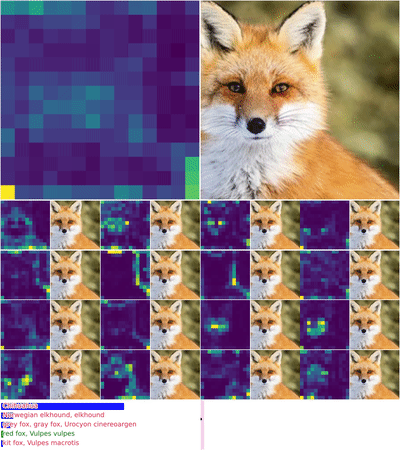

In [12]:
# Fazer uma pasta para o output - gif
out_path = "01_output"
os.makedirs(out_path, exist_ok=True)
make_gif(predictions, certainties, attention_tracking, target, out_path, dataset_mean, dataset_std);


### Conclusão: Por que isso importa?


A pesquisa do laboratório Sakana AI nos dá mais do que uma IA que acerta; ela nos dá uma IA que nos permite entender como ela chega às suas conclusões.
E se ela errasse? E quando reproduz preconceitos? Esse processo transparente significa maior clareza e possibilidade de intervenção e pesquisa. Ou seja, um passo importante em direção a uma tecnologia mais transparente e confiável.
Em vez de uma "caixa-preta" que simplesmente oferece resultados, as Máquinas de Pensamento Contínuo nos convidam a acompanhar, valorizar e exigir o desenvolvimento de inteligência artificial que não apenas computa, mas que nos permite observar e compreender esse processo de "raciocínio" artificial.


### Extra

In [ ]:
plot_neural_dynamics(post_activations, 15*10, out_path, axis_snap=True, N_per_row=15);

  0%|          | 0/150 [00:00<?, ?it/s]

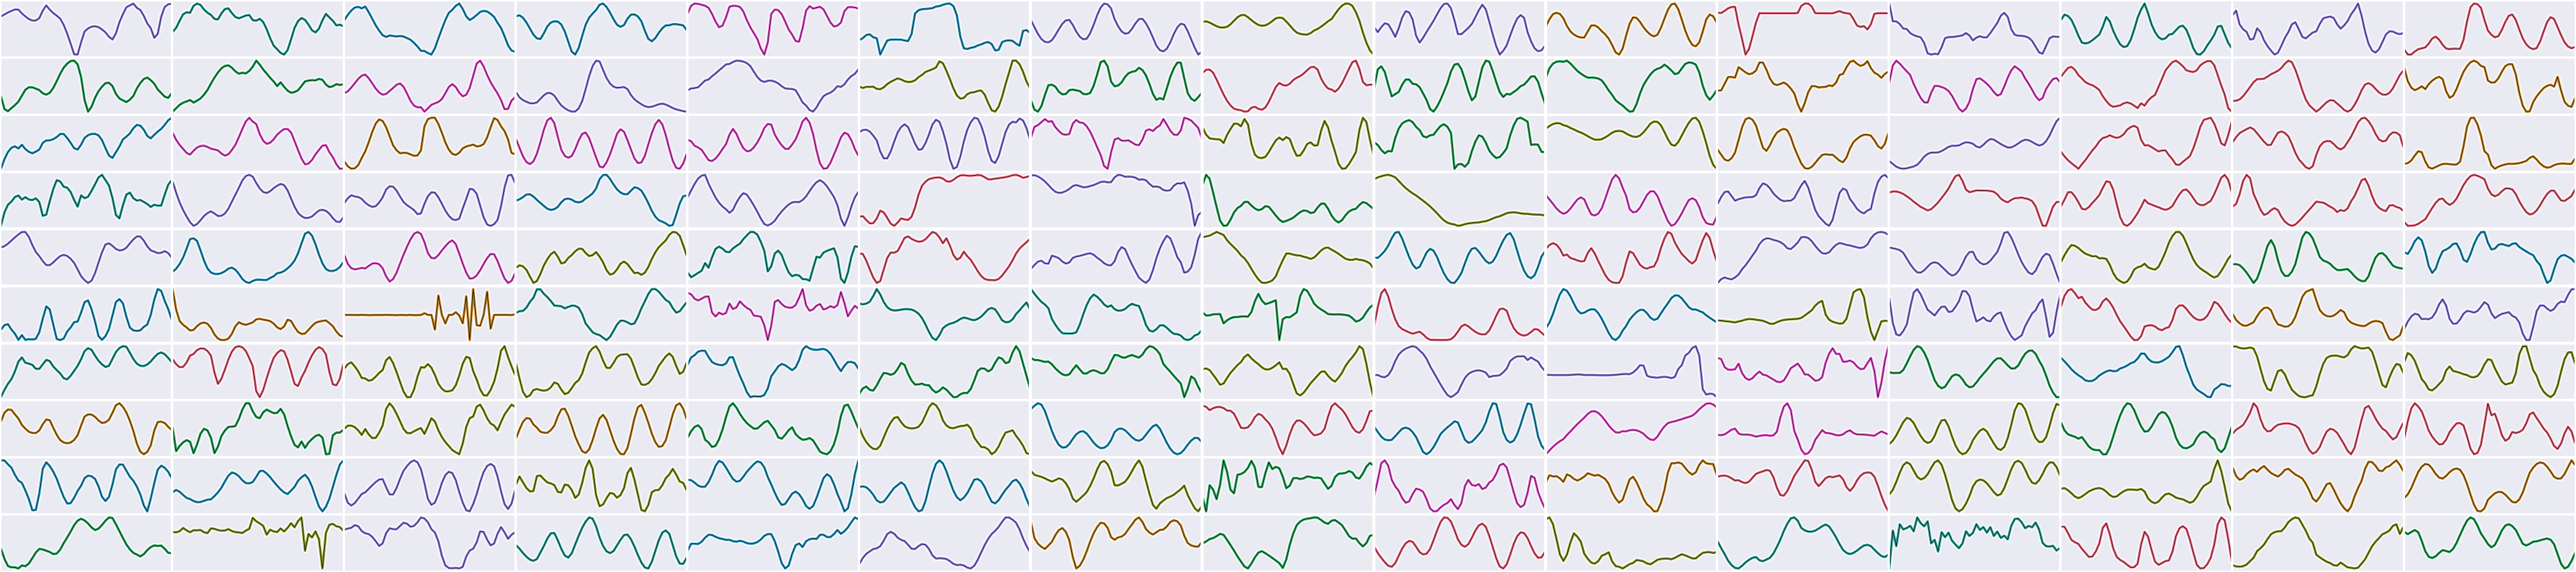

In [ ]:
display(IPyImage(filename=f'{out_path}/neural_dynamics_synch.png'))